In [1]:
from common.np import *

# Chapter 5. RNN

## \# 5.5.4 `RnnlmTrainer` 구현

- 지금까지 구현한 모든 class들을 python 파일로 옮기고, Trainer 객체로 사용

In [2]:
import time
import numpy
from common.trainer import remove_duplicate
import matplotlib.pyplot as plt
from common.util import clip_grads

In [3]:
class RnnlmTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.time_idx = None
        self.ppl_list = None
        self.log_step = None
    
    
    def get_batch(self, xs, ts, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        
        data_size = len(xs)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]
        
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + self.time_idx) % data_size]
                batch_t[i, t] = ts[(offset + self.time_idx) % data_size]
            self.time_idx += 1
            
        return batch_x, batch_t
    
    
    def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35, max_grad=None, \
            loss_save_step=20, log_step=20):
        data_size = len(xs)
        max_iters = data_size // (batch_size * time_size)
        self.time_idx = 0
        self.ppl_list = []
        self.loss_save_step = loss_save_step
        model, optimizer = self.model, self.optimizer
        total_loss, loss_count = 0, 0
        
        start_time = time.time()
        for epoch in range(max_epoch):
            for iters in range(max_iters):
                batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)
                
                # loss
                loss = model.forward(batch_x, batch_t)

                # back propagation
                model.backward()
                # 공유되어서 중복된 가중치는 하나만 남겨두기
                params, grads = remove_duplicate(model.params, model.grads)

                # max_grad값 있으면 그 값에 맞게 조정
                if max_grad is not None:
                    clip_grads(grads, max_grad)

                # update gradient
                optimizer.update(params, grads)

                total_loss += loss
                loss_count += 1

                # save loss
                if (iters+1) % self.loss_save_step == 0:
                    avg_loss = total_loss / loss_count
                    ppl = np.exp(avg_loss)
                    self.ppl_list.append(float(ppl))
                    total_loss, loss_count = 0, 0

                # log losses
                if (iters+1) % log_step == 0:
                    elapsed_time = time.time() - start_time
                    print("time %ds | epoch %d | step %d / %d | ppl %.2f" % (elapsed_time, epoch+1, \
                                                                             iters+1, max_iters, ppl))
        
        
    def plot(self, ylim=None):
        x = numpy.arange(len(self.ppl_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.ppl_list, label='train')
        plt.xlabel('iter (x' + str(self.loss_save_step) + ')')
        plt.ylabel('perplexity')
        plt.show()
                    

---
### `Trainer` 객체 사용해서 학습

In [4]:
from common.simple_models import SimpleRnnlm
from common.optimizer import SGD
from common.dataset import PTB

In [5]:
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5 # Truncated BPTT 블록 안의 RNN 개수
lr = 0.1
max_epoch = 100
log_step = 10

In [6]:
ptb = PTB()
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

In [7]:
xs = corpus[:-1]
ts = corpus[1:]

In [8]:
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

In [9]:
trainer.fit(xs, ts, max_epoch, batch_size, time_size, loss_save_step=10, log_step=19)

time 0s | epoch 1 | step 19 / 19 | ppl 401.78
time 0s | epoch 2 | step 19 / 19 | ppl 285.65
time 0s | epoch 3 | step 19 / 19 | ppl 227.36
time 0s | epoch 4 | step 19 / 19 | ppl 216.56
time 0s | epoch 5 | step 19 / 19 | ppl 211.00
time 0s | epoch 6 | step 19 / 19 | ppl 204.40
time 0s | epoch 7 | step 19 / 19 | ppl 199.39
time 0s | epoch 8 | step 19 / 19 | ppl 194.25
time 0s | epoch 9 | step 19 / 19 | ppl 192.96
time 0s | epoch 10 | step 19 / 19 | ppl 193.63
time 0s | epoch 11 | step 19 / 19 | ppl 192.26
time 0s | epoch 12 | step 19 / 19 | ppl 195.12
time 0s | epoch 13 | step 19 / 19 | ppl 188.33
time 0s | epoch 14 | step 19 / 19 | ppl 186.42
time 0s | epoch 15 | step 19 / 19 | ppl 190.48
time 0s | epoch 16 | step 19 / 19 | ppl 185.87
time 0s | epoch 17 | step 19 / 19 | ppl 188.09
time 0s | epoch 18 | step 19 / 19 | ppl 184.50
time 0s | epoch 19 | step 19 / 19 | ppl 182.37
time 0s | epoch 20 | step 19 / 19 | ppl 182.40
time 0s | epoch 21 | step 19 / 19 | ppl 178.26
time 0s | epoch 22 | s

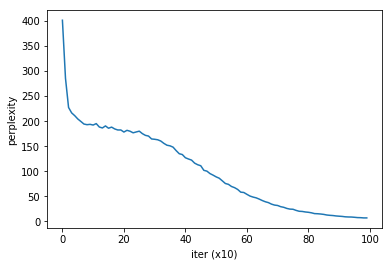

In [10]:
trainer.plot()